<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 Pytorch Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [1]:
# Set your student number
student_number = 98106061
Name = 'Sayyed Mohammad Pourya'
Last_Name = 'Momtaz Esfahani'

# Rules
- You **are** allowed to add or remove cells. 
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [2]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q2.ipynb")
with open(f'python_code_Q2_{student_number}.py', 'w') as file:
    file.write(python_code)

your file will be graded


# PyTorch & MNIST Classification (50 points+5 Extra)

<font size=4>
Author: Arman Zarei
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this assignment, you are going to learn the fundamentals of PyTorch and implement a classifier network for MNIST dataset. You can read about more details of PyTorch components from [this link](https://pytorch.org/tutorials).

### Setup

In [3]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from Helper_codes.ae_helper import init_mnist_subset_directories
import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Loading dataset

In [5]:
mnist_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Autograd

Autograd is PyTorch's automatic differentiation engine that powers neural network training. In essence it helps us to calculate derivatives and updating parameters. To read more about Autograd and Computational Graph visit [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

Let us define two parameters: $p_1$ and $p_2$. 

In [6]:
p1 = torch.tensor([3.], requires_grad=True)
p2 = torch.tensor([7.], requires_grad=True)

Now define a variable $L$ as below:

$L = 3 \times p_1^3 - 7 \times p_2^2 + sin(p1) \times p_2^2$

In [7]:
L =  torch.add(torch.sub(torch.mul(torch.pow(p1, 3), 3), torch.mul(torch.pow(p2, 2), 7)), torch.mul(torch.sin(p1),torch.pow(p2, 2)))

Now you have to calculate the gradient of $p_1$ and $p_2$ with respect to $L$. First do it by hand and write the mathematical expression in the below cell both for $p_1$ and $p_2$. Then evaluate them at $3$ and $7$ (acording to the initialization)

Place your expressions here **(2.5 Points)**


$\frac{dL}{dp_1} =9*p_1^2+p_2^2*cos(p_1)$ 

$\frac{dL}{dp_2} =-14*p_2+sin(p_1)*2*p_2$

$\frac{dL}{dp_1}(3, 7) =32.4903$

$\frac{dL}{dp_2}(3, 7) =-96.0243$

In [8]:
# Place your code here (optional)
## For calculation of dL/dp in the given point

Now let's calculate this using pytorch. The below code will construct the computational graph and stores the gradient of each variable inside of it.

In [9]:
L.backward()

Check whether the result of your calculations is the same with the autograd's output.

In [10]:
print(f"P_1 grad: {p1.grad.item()}\nP_2 grad: {p2.grad.item()}")

P_1 grad: 32.4903678894043
P_2 grad: -96.02432250976562


## Transform 

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training. For more details, you can read [this link](https://pytorch.org/vision/stable/transforms.html)

There are many transformations that are already implemented inside pytorch that you can use. Here we are going to implement some transformation from scratch using PyTorch's framework.

#### Random Horizontal Flip Transformation

Define a transformation that flips the image (horizontally) with probability of $p$. In order to implement a simple transformation class, you need to have two methods: `__init__` and `__call__` (which receives the image)

In [11]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.prob = p
  
    def __call__(self, x):
        p = self.prob
        self.flip = np.random.choice([0, 1], p=[1-p, p])
        if self.flip == 1:
            row_size = x.shape[1]
            column_size = x.shape[0]
            zeros_tensor = torch.zeros((column_size, 1))
            axis = row_size/2
            for i in range(int(axis)):
                zeros_tensor = torch.clone(x[:, i])
                x[:, i] = x[:, row_size - i  - 1]
                x[:, row_size - i  - 1] = zeros_tensor
            return x
        else:
            return x

#### Random Color Swap

Now that you have learned how to implement a transformation class, let's build another one. Define a transformation which swaps the colors (in the gray scale image) with probability of $p$. For example, if the given image had a white colored number with a black background, it should output an image with black colored number and a white background.

**Hint:** for a given input $x$, you can concider the swapped color version of it as $x_{new} = m - x$ where $m$ is the maximum value in image $x$

In [12]:
class RandomColorSwap(object):
    def __init__(self, p=0.5):
        self.prob = p
  
    def __call__(self, x):
        p = self.prob
        self.swap = np.random.choice([0, 1], p=[1-p, p])
        if self.swap == 1:
            row_size = x.shape[1]
            column_size = x.shape[0]
            ones_tensor = torch.ones((column_size, row_size))
            return torch.sub(torch.mul(ones_tensor, torch.max(x)), x)
        else:
            return x

### Evaluation of transformations

Now, let's apply these transformations on some images of our dataset. You can stack different transformation using `Compose`

In [13]:
trans = transforms.Compose([
  RandomHorizontalFlip(p=0.7),
  RandomColorSwap()
])

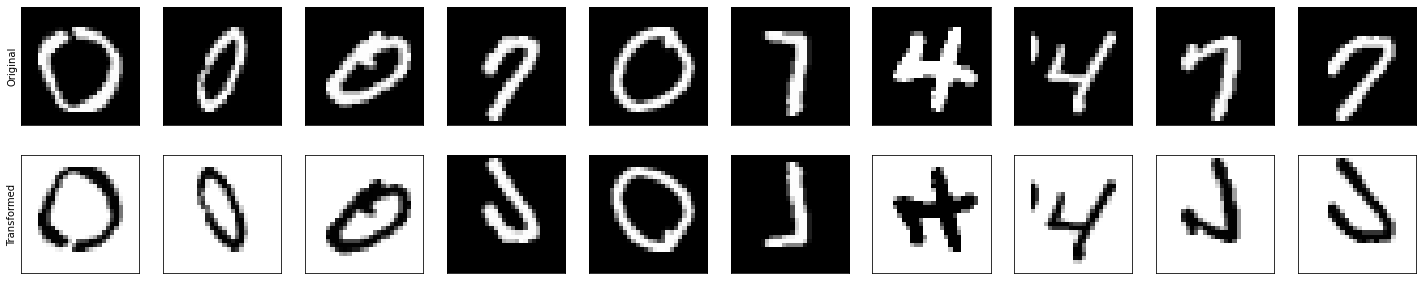

In [14]:
num_imgs = 10
fig, axs = plt.subplots(2, num_imgs, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(mnist_dataset), [num_imgs])):
    x, y = mnist_dataset[idx]
    axs[0, i].imshow(x[0], cmap='gray')
    axs[1, i].imshow(trans(x)[0], cmap='gray')
    for k in range(2):
        axs[k, i].set_yticks([])
        axs[k, i].set_xticks([])

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Transformed");

What we expect to see is that, some of them are fliped horizontally, some swapped in color, and some both.

## Dataset

In this section, we are going to implement a dataset class. Inside `torchvision.datasets` there are many Datasets that are already implemented and ready to use. But, in many situations it's necessary to implement one by your self.

Run the below cell to initialize our dataset

In [15]:
dataset_path = "new_mnist"
init_mnist_subset_directories(mnist_dataset, dataset_path)

100%|██████████| 5000/5000 [00:02<00:00, 2033.94it/s]


If you take a look at `new_mnist` directory which is created in the directory you are working in, you see that it contains 10 folders with names from `0` to `9` indicating the label of the images inside it. Inside each, some files with name `data_{number}.pth` exist. Each `.pth` file is an image.

Now you have to implement a Dataset on top of these files.
The methods that you should implement in a Dataset (as you can see in the code) is as described below:
- `__init__`: In our example assume that it only accepts `root_dir` and `transform` as it's parameters (You should apply the transformations before outputing the data)
- `__len__`: Should return the number of data in your dataset
- `__getitem__`: which receives an index, should return the data at the given index (which is a tuple here, containing image and the corresponding label) 

In [16]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.length = 0
        self.dataset = dict()
        for i in range(10):
            self.dataset[i]=dict()
            path = f"{root_dir}/{i}"
            #path2 = f"{root_dir}2/{i}"
            self.length += len(os.listdir(path))
            path += '/'
            for f in os.listdir(path):
                file_path = path+f
             #   path2 += f
                data = torch.load(file_path)
                transformed = transform(data)
                self.dataset[i][f[5:-4]]=transformed
              #  torch.save(transformed, path2)
        pass

    def __len__(self):
        return self.length
        pass

    def __getitem__(self, idx):
        for i in range(10):
            if idx in self.dataset[i]:
                return (self.dataset[i][idx],i)

After you defined your dataset, let's use it.

In [17]:
my_dataset = MNISTDataset(root_dir=dataset_path, transform=RandomColorSwap())
len(my_dataset)

5000

Visualize 10 samples (randomely) from your dataset with their labels

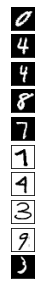

In [18]:
num_imgs = 10
fig, axs = plt.subplots(num_imgs, figsize=(25,5))
for i, idx in enumerate(torch.randint(0, len(my_dataset), [num_imgs])):
    x, y = my_dataset[str(idx.numpy())]
    axs[i].imshow(x[0], cmap='gray')
    axs[i].set_yticks([])
    axs[i].set_xticks([])
plt.show()

## MNIST Classification

### Model
Define your model (Based on what you have learned in the workshop). I highly encourage you to try different models with different layers in order to achieve a better accuracy

**Notice:** You cannot use convolution layers in your model 

In [107]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(           
            nn.Flatten(),                       \
            nn.Linear(784, 3136), 
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(3136, 1024), 
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x

In [108]:
model = DigitRecognizer().to(device)
model

DigitRecognizer(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=3136, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=3136, out_features=1024, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=1024, out_features=10, bias=True)
  )
)

### Dataset and Dataloader

Prepare datasets and dataloader for train/test. We use MNIST dataset that is already implemented inside `torchvision.datasets`.

 You need to split the `mnist_dataset` into `train_dataset` and `val_dataset`. 
 
 You can also define more transformations that you think it would help the training process **(Optional)**.

In [109]:
transform_compose = transforms.Compose([
    transforms.ToTensor(),
    RandomColorSwap()
])

mnist_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transform_compose)
train_size = int(0.9*len(mnist_dataset))
val_size = len(mnist_dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, (train_size, val_size))

# End of block for your code placement
test_dataset = datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

### Criterion and Optimizer

you have to tune the `learning_rate` yourself (Based on your training process)

In [110]:
criterion = nn.CrossEntropyLoss()
learning_rate= 4*1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train your model

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). You also need to store train/validation loss at each epoch in order to visualize them the after training is done.

In [111]:
num_epochs=10

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    train_true, val_true= 0, 0
    train_all, val_all = 0, 0
    i = 0
    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)
            train_loss += float(loss)*32

            predictions = p.argmax(-1)
            train_all += float(len(predictions))
            train_true += float((predictions == y).sum())

            pbar.set_description(f'Loss: {train_loss / (i + 1):.3e} - Acc: {train_true * 100. / train_all:.2f}%')
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
  
    i = 0
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)
            val_loss += float(loss)*32

            predictions = p.argmax(-1)
            val_all += float(len(predictions))
            val_true += float((predictions == y).sum())

            pbar.set_description(f'Loss: {val_loss / (i + 1):.3e} - Acc: {val_true * 100. / val_all:.2f}%')


    train_loss /= len(train_loader.dataset)
    train_true /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_true /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    print(f"[Epoch {epoch}]\t"
        f"Train Acc: {train_true:.4f}\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Acc: {val_true:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

Loss: 8.063e+00 - Acc: 92.53%: 100%|██████████| 188/188 [00:03<00:00, 61.80it/s]


[Epoch 0]	Train Acc: 0.8474	Train Loss: 0.4831	Validation Acc: 0.9253	Validation Loss: 0.2527


Loss: 6.055e+00 - Acc: 94.25%: 100%|██████████| 188/188 [00:02<00:00, 64.41it/s]


[Epoch 1]	Train Acc: 0.9021	Train Loss: 0.3088	Validation Acc: 0.9425	Validation Loss: 0.1897


Loss: 5.841e+00 - Acc: 94.52%: 100%|██████████| 188/188 [00:02<00:00, 63.96it/s]


[Epoch 2]	Train Acc: 0.9178	Train Loss: 0.2595	Validation Acc: 0.9452	Validation Loss: 0.1830


Loss: 5.393e+00 - Acc: 94.58%: 100%|██████████| 188/188 [00:02<00:00, 63.93it/s]


[Epoch 3]	Train Acc: 0.9260	Train Loss: 0.2338	Validation Acc: 0.9458	Validation Loss: 0.1690


Loss: 6.518e+00 - Acc: 93.53%: 100%|██████████| 188/188 [00:02<00:00, 63.18it/s]


[Epoch 4]	Train Acc: 0.9330	Train Loss: 0.2173	Validation Acc: 0.9353	Validation Loss: 0.2042


Loss: 4.348e+00 - Acc: 95.90%: 100%|██████████| 188/188 [00:02<00:00, 63.62it/s]


[Epoch 5]	Train Acc: 0.9382	Train Loss: 0.1990	Validation Acc: 0.9590	Validation Loss: 0.1362


Loss: 5.207e+00 - Acc: 95.12%: 100%|██████████| 188/188 [00:03<00:00, 61.57it/s]


[Epoch 6]	Train Acc: 0.9385	Train Loss: 0.1931	Validation Acc: 0.9512	Validation Loss: 0.1632


Loss: 5.708e+00 - Acc: 94.63%: 100%|██████████| 188/188 [00:02<00:00, 63.45it/s]


[Epoch 7]	Train Acc: 0.9428	Train Loss: 0.1834	Validation Acc: 0.9463	Validation Loss: 0.1788


Loss: 4.496e+00 - Acc: 95.73%: 100%|██████████| 188/188 [00:02<00:00, 62.85it/s]


[Epoch 8]	Train Acc: 0.9446	Train Loss: 0.1766	Validation Acc: 0.9573	Validation Loss: 0.1409


Loss: 4.166e+00 - Acc: 96.28%: 100%|██████████| 188/188 [00:03<00:00, 61.55it/s]

[Epoch 9]	Train Acc: 0.9485	Train Loss: 0.1640	Validation Acc: 0.9628	Validation Loss: 0.1305


#### Plot train/validation loss

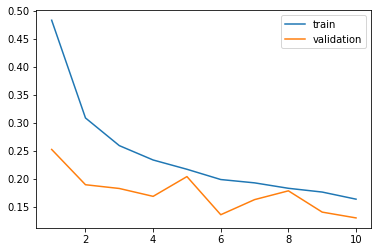

In [113]:
x1 = [1, 2, 3, 4, 5 ,6 , 7, 8, 9, 10] #epoch num
y1 = list(train_loss_arr)
y2 =list(val_loss_arr)
plt.plot(x1, y1)
plt.plot(x1, y2)

plt.legend(["train", "validation"])

### Evaluation

Evaluate your model on test set. you have to report both loss and accuracy.

In order to get the full score of this section, you need to achieve an accuracy above $95\%$ and to get the extra points, your accuracy should be above $98\%$ 

**Notice:** You should use test set only for evaluation of your model.

In [114]:
    test_loss = 0
    test_true= 0
    test_all = 0
    i = 0
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)
            test_loss += float(loss)*32

            predictions = p.argmax(-1)
            test_all += float(len(predictions))
            test_true += float((predictions == y).sum())

            pbar.set_description(f'Loss: {test_loss / (i + 1):.3e} - Acc: {test_true * 100. / test_all:.2f}%')

Loss: 2.054e+00 - Acc: 98.14%: 100%|██████████| 313/313 [00:03<00:00, 85.69it/s]


### Visualization of wrong prediction

Visualize $8$ samples (along with original label and model's prediction) from test set which are labeled wrong by your model

  4%|▍         | 14/313 [00:00<00:02, 145.87it/s]


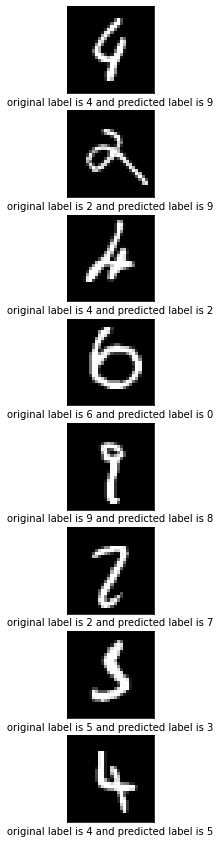

In [155]:
    test_loss = 0
    test_false= 0
    test_all = 0
    i = 0
    cnt = 8
    false_predictions = list()
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
        for i, (x, y) in pbar:
            if cnt == 0:
              break
            x = x.to(device)
            y = y.to(device)
            p = model(x)
            loss = criterion(p, y)
            test_loss += float(loss)*32
            predictions = p.argmax(-1)
            if not torch.equal(predictions, y):
              compare_list = torch.eq(predictions, y)
              for diff in range(len(compare_list)):
                if not compare_list[diff]:
                  false_predictions.append((x[diff], y[diff], predictions[diff]))
                  cnt -= 1
                  if cnt == 0:
                    break

              

    num_imgs = 8
    fig, axs = plt.subplots(num_imgs, figsize=(15,15))
    for i in range(num_imgs):
        x, y, prediction = false_predictions[i]
        x = x.to('cpu')
        y = y.to('cpu')
        prediction = prediction.to('cpu')
        axs[i].imshow(x[0].numpy(), cmap='gray')
        axs[i].set_yticks([])
        axs[i].set_xticks([])
        txt=f"original label is {y.numpy()} and predicted label is {prediction.numpy()}"
        axs[i].set_xlabel(txt)
    plt.show()